In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import random
import itertools
import scipy
from matplotlib import pyplot
from math import sqrt
from networkx.classes import Graph
from networkx.classes import set_node_attributes
from networkx.algorithms.minors import contracted_nodes
from networkx.algorithms.operators.product import cartesian_product
from networkx.exception import NetworkXError
from networkx.relabel import relabel_nodes
from networkx.utils import flatten
from networkx.utils import nodes_or_number
from networkx.utils import pairwise
from networkx.generators.classic import cycle_graph
from networkx.generators.classic import empty_graph
from networkx.generators.classic import path_graph

from statistics import mean
from itertools import zip_longest
import operator
import statistics
import statistics as stat
import statistics as stats
import itertools
from copy import deepcopy
import copy
from scipy.stats  import multivariate_normal
import matplotlib 
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
from IPython.core.debugger import set_trace
import random
import time
import math
import seaborn as sns; sns.set()
import pylab
from random import randrange
import sys 
import scipy
import plotly.graph_objects as go
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy.ma as ma
import multiprocessing as mp
from IPython.core.debugger import Tracer

import warnings
warnings.filterwarnings("ignore")

### KEM in network
In this model, I am initializing a network with different topological characteristics.
Initially, each nodes have the following characteristics:


wealth: random uniform distribution.
     
     
$ \eta$: random power distribution.
     
     
income: random uniform distribution.
     
     
return: constant (0.03).
    

    
At each iteration, based on the equation (4) from Vicky's document:
$ I_i (t+1)= r w_{i}(t) + (1- \eta_{i})I_{j}(t)$

I am extending to the whole system. In this case, in each iteration I am taking the whole network and considering the adjacency matrix of it. I will consider the weight of each edge is just 1/number of neighbors, in order to make sure that each cell is not using more than its $(1- \eta_{i})I_{j}(t)$ spending amount. 

Then, I consider P, as the adjacency of the matrix of the whole grid.

S is a vector that contains the total amount that each cell is willing to spend in each transaction ($(1- \eta_{i})I_{j}(t)$).

wealth is a vector that contains the total wealth of each cell times the return rate (in this case, this value is 1.003).

Then, the new income of each cell of the grid is the product between the adjacency matrix P and the S vector (spending vector) + wealth.

We make sure to update this in each iteration, including the wealth defined as:
$w_{i}(t)=w_{i}(t+1) + I(t)$


In [159]:
class interactive_kem:
    
    
    def __init__(self, network_size = 100, network = 'Small World'): #, clusters=2):
        '''
        Initialize with network_size input.
        network. str. indicates the network type.
        k. int. indicates the number of clusters in the network.
        
        '''
        self.network_size = network_size
        self.network = network
#         self.clusters = clusters
        self.populate()
        
        
    def populate(self):
        '''
        Creating a network of certain topological features,
        Nodes have a individual wealth (random uniform), eta (random power), income (random uniform) values,
        and a contant return rate for all the grid. 
        
        
        Small world: Returns a Watts-Strogatz small-world graph.
        Random: Returns a random graph, also known as an Erdős-Rényi graph or a binomial graph.
        Complete: Returns the complete graph K_n with n nodes.
        Clusters: Returns two complete graphs connected with a edge for every 100 nodes.
        Special case: Returns two small-world graphs connected with a edge for every 100 nodes.
        
        '''
        if self.network != 'Special Case' and self.network != 'Cluster':
        # creating graphs according to inputs
            
            if self.network == 'Small World':
                self.graph = nx.watts_strogatz_graph(n=self.network_size, k = int(3+ int(self.network_size/20)), p= 0.5)
                    
            if self.network == 'Random':
                self.graph = nx.fast_gnp_random_graph(n=self.network_size, p= 0.1, directed = False)
            
            if self.network == 'Complete':
                self.graph = nx.complete_graph(n=self.network_size)
            
#             if self.network == 'Clusters':
#                 self.graph = nx.connected_caveman_graph(l = self.clusters, k = int(self.network_size/ self.clusters))
            
#             for node in self.graph.nodes:
#                 self.graph.nodes[node]['wealth'] = np.random.uniform(0, 100)
#                 self.graph.nodes[node]['eta'] = np.random.power(0.3)
#                 self.graph.nodes[node]['income'] = np.random.uniform(0, 100)
#     #             self.graph.nodes[node]['return'] = 0.03
    

                

        if self.network == 'Special Case':

            a = nx.watts_strogatz_graph(n= int(self.network_size/2), k = int(3+ self.network_size/40), p= 0.5)
            b = nx.watts_strogatz_graph(n= int(self.network_size/2), k = int(3+ self.network_size/40), p= 0.5)
            
            self.graph = nx.disjoint_union(a,b)
            
            n_edges = int(self.network_size/100)
            #for every 100 nodes, we will be adding one link between the clusters 
            for _ in range(n_edges):
                self.graph.add_edge(np.random.choice(range(int(self.network_size/2))), np.random.choice(range(int(self.network_size/2), int(self.network_size))))

                
                
        if self.network == 'Clusters':

            a = nx.complete_graph(n=int(self.network_size/2))
            b = nx.complete_graph(n=int(self.network_size/2))
            self.graph = nx.disjoint_union(a,b)
            
            n_edges = int(self.network_size/100)
            
            #for every 100 nodes, we will be adding one link between the clusters 
            for _ in range(n_edges):
                self.graph.add_edge(np.random.choice(range(int(self.network_size/2))), np.random.choice(range(int(self.network_size/2), int(self.network_size))))
        
        # filling each node with wealth, income and saving rate
        for node in self.graph.nodes:
            self.graph.nodes[node]['wealth'] = np.random.uniform(50, 100)
            self.graph.nodes[node]['eta'] = np.random.power(0.3)
            self.graph.nodes[node]['income'] = np.random.uniform(50, 100)


    def gini(self, p):
        '''
        Gini coefficient (equation from wikipedia)
        
        '''
    
        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n
    
    def percent(self, pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]

    def hist(self, p, label='Dist', **kwargs):
        '''
        Histogram function with specific characteristics. 
        '''
        
        label = label + ': G=' + str(round(self.gini(p), 2))

        h = plt.hist(list(p), alpha = 0.4, bins = 30, label= label, **kwargs)

        plt.xlabel('Income')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()
        
#     def observe(self):
#         '''
#         Draw the state of the network.
#         '''
#         self.layout = nx.spring_layout(self.graph, pos = self.layout)#, iterations=5)
#         plt.clf()
#         nx.draw(
#             self.graph, pos=self.layout,
#             node_color=[self.graph.nodes[i]['income'] for i in self.graph.nodes],
#             edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
#             edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
#             alpha=0.7, vmin=0, vmax=1)
#         plt.title('Step: ' + str(self.step))

    def simulate(self, steps):
        '''
        This function update the whole network in a certain number of steps. 
        In each iteration the nodes are interacting with their respective neighbors, 
        according to the adjacency matrix. This updating function is based on the 
        functions described above, and in the paper.
        
        '''
        normalized = []
        results = []
        norm_sorted_results = []
        sorted_results = []
        times = []
        
        # including the initial distribution
        a = np.array(list(self.graph.nodes(data ='income')))
        a= list(a[:, 1])
        
        normalized.append(a/np.mean(a))
        results.append(a)
        norm_sorted_results.append(sorted(a/np.mean(a)))
        sorted_results.append(sorted(a))
        times.append(0)
        
        return_ = 0.003
        
        #stationary adjacency matrix
        n_neighbors = []
        for _ in list(self.graph.nodes):
            n_neighbors.append(1/len(list(self.graph.neighbors(_))))
        
        n_neighbors_vec =np.array(n_neighbors)
        #original adjacency matrix
        adj_mx = np.array(nx.adjacency_matrix(self.graph, nodelist=None, weight='weight').todense())
        
        #normalize the neighbors by the total, so we do not exceed to amount per person
        P = adj_mx * n_neighbors_vec.transpose()
        
        for t in range(1, steps+1):
#             if t % (self.network_size*10) == 0:

                # (1-\eta) * income for each element
                S = [(1-e)*i for ((_, e) , (_, i)) in zip(list(self.graph.nodes(data='eta')), list(self.graph.nodes(data='income')))]
                
                # r*w vector where r is an constant scalar in this case
                wealth = [i*(1+return_) for _,i in list(self.graph.nodes(data='wealth'))]
                
                # new_income = r*w + P S where P is the adjacency matrix, S is the amount of money that a node is 
                # willing to spend in each transaction
                inc = P.dot(S)
                
                new_income = wealth + P.dot(S)
                new_income = new_income.tolist()
                
                #updating the functions
                for (i, w), j, c in zip(list(self.graph.nodes(data='wealth')), new_income, inc):
                    self.graph.nodes[i]['income']=  j 
                    self.graph.nodes[i]['wealth']=  self.graph.nodes[i]['wealth'] + c
                                                                                                                                                   
                normalized.append(new_income/np.mean(new_income))
                results.append(new_income)
                norm_sorted_results.append(sorted(new_income/np.mean(new_income)))
                sorted_results.append(sorted(new_income))
                
                times.append(t)
                
                
#                 def growth(population):
#                     '''
#                     Function to calculate the growth rate of the different percentiles.
                    
#                     '''
#                     growth_rate = []
#                     for pop in range(1, len(population)):
#                         gnumbers = ((population[pop] - population[pop-1]) / population[pop-1] * 100)
#                         growth_rate.append(gnumbers)
#                     return growth_rate

#                 self.growth_percs = []

                percentiles=(1, 10, 50, 90, 99)

                self.lines = []
                for pct in percentiles:
                    line = [self.percent(pct, pop) for pop in sorted_results]
                    self.lines.append(line)
                
                
        return normalized, results, norm_sorted_results, sorted_results, times
        
        
    def show(self, percentiles=(1, 10, 50, 90, 99), **kwargs):
        '''
        Print stats, plot and histogram
        
        '''
        N = self.network_size
        start = np.array(list(self.graph.nodes(data ='income')))
        start= list(start[:, 1])
        start = start/np.mean(start)
        
        
        normalized, results, norm_sorted_results, sorted_results, times = self.simulate(steps = 100)
        
#         # Statistics
#         print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    
#         fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
                
#         for (t, pop) in zip(times, sorted_results):
#             if t % (10) == 0:
#                 data = [self.percent(pct, pop) for pct in percentiles]
#                 print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))
        
#         print('Avg. shortest path length:', nx.average_shortest_path_length(self.graph, weight=None))
        # Plot
        
#         def growth(population):
#             growth_rate = []
#             for pop in range(1, len(population)):
#                 gnumbers = ((population[pop] - population[pop-1]) / population[pop-1] * 100)
#                 growth_rate.append(gnumbers)
#             return growth_rate
        

        plt.xlabel('Time')
        plt.ylabel('Income')
        plt.grid(True)
        
#         self.growth_percs = []
        
        self.lines = []
        for pct in percentiles:
            line = [self.percent(pct, pop) for pop in sorted_results]
            self.lines.append(line)
            plt.plot(times, line)
            
#             print(line)
#             self.growth_percs.append(np.mean(growth(line)))
        
        plt.yscale('log')
        plt.show()
            
            
        # Histogram
        
        pop = normalized[-1]
        R = (min(pop+start), max(pop+start))
        
        fig = plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        self.hist(start, 'Initial', range=R)
        
        plt.subplot(1, 2, 2)
        self.hist(pop, 'Final', range=R)
#         plt.xscale('log')
        plt.show()
        plt.close() 
        

### Comparison of Network topologies 
In the next cell we are running different initial network topologies, varying the cluster and modularity of the network, to determine how these features affect the economic output of the system at different levels of analysis. We are analyzing the decile trajectories, and the initial and final distributions of the networks.

In [84]:
def percent(pct, items):
    '''
    The item that is pct percent through the sorted list of items.

    '''
    return items[min(len(items)-1, len(items) * pct // 100)]

def gini(p):
        '''
        Gini coefficient (equation from wikipedia)
        
        '''
    
        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n

def hist(p, label='Dist', **kwargs):
        '''
        Histogram function with specific characteristics. 
        '''
        
        label = label + ': G=' + str(round(gini(p), 2))

        h = plt.hist(list(p), alpha = 0.3, bins = 30, label= label, **kwargs)

        plt.xlabel('Income')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()
        
def show(lst_means, df_means):
    
    #plot 
    plt.xlabel('Time')
    plt.ylabel('Income')
    plt.grid(True)

    percentiles=(1, 10, 50, 90, 99)
    
    for pct in percentiles:
        line = [percent(pct, pop) for pop in lst_means]
        plt.plot(range(df_means.shape[0]), line)
        
    plt.show()
    
    #histogram
    
    N = sim.network_size
    start = lst_means[0]
    pop = lst_means[-1]
    
    R = (min(pop+start), max(pop+start))

    fig = plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    hist(start, label = 'Initial', range=R)

    plt.subplot(1, 2, 2)
    hist(pop, label = 'Final', range=R)
    
    plt.show()
    plt.close() 

Small World


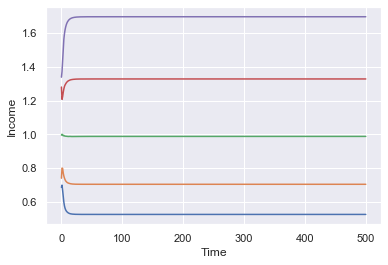

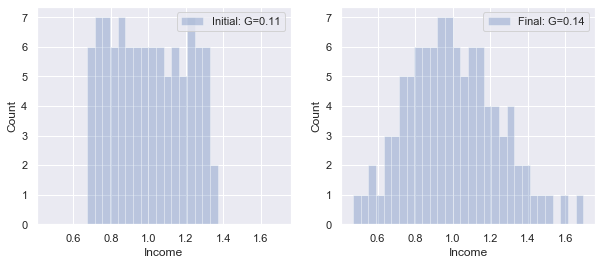

Random


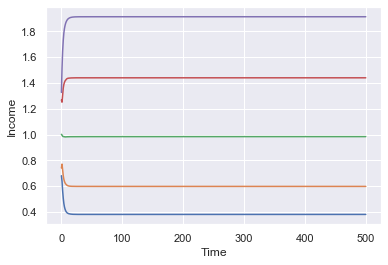

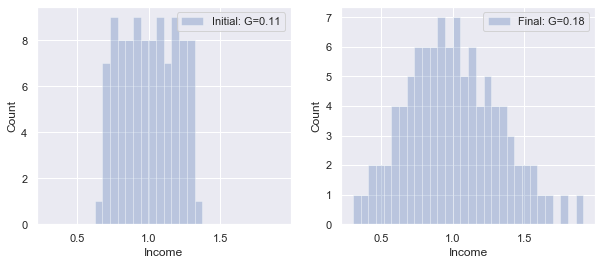

Complete


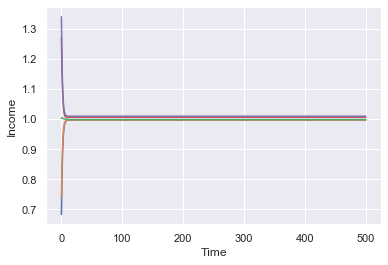

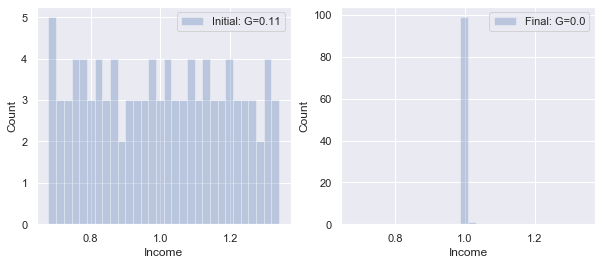

Clusters


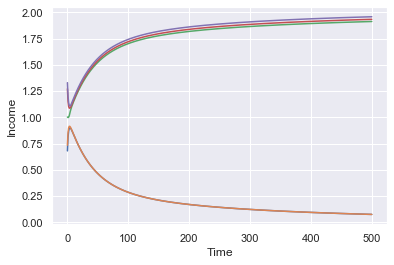

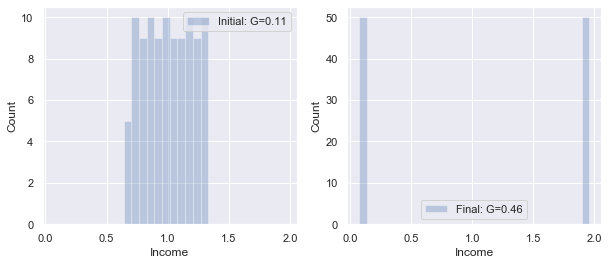

Special Case


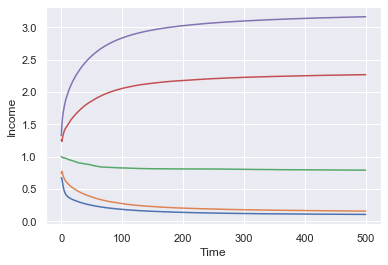

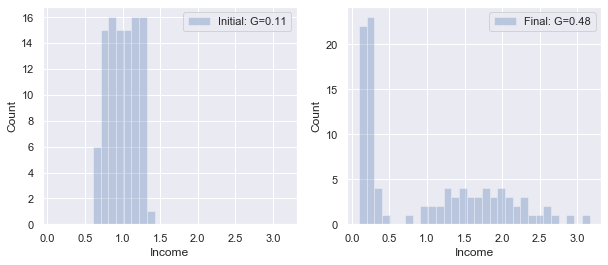

In [85]:
'''

In this function, we are averaging the results from the same network structure
through time, and analyzing initial and final income distribution.

'''

#Population 100


networks = ['Small World', 'Random', 'Complete', 'Clusters', 'Special Case']

for i in networks:
    print(i)
    all_df = []
            
    
    for _ in range(30): 
        sim = interactive_kem(network = i)
        normalized, results, norm_sorted_results, sorted_results, times = sim.simulate(steps = 500) #(5 steps (with initial dist))
        
        norm_df = pd.DataFrame(sorted_results)
        all_df.append(norm_df)
        
        
        
    df_concat = pd.concat(all_df)
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    lst_means = df_means.values.tolist()
    
    show(lst_means, df_means)
    
    

Small World


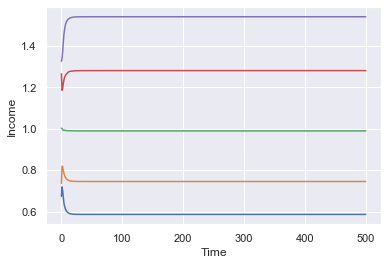

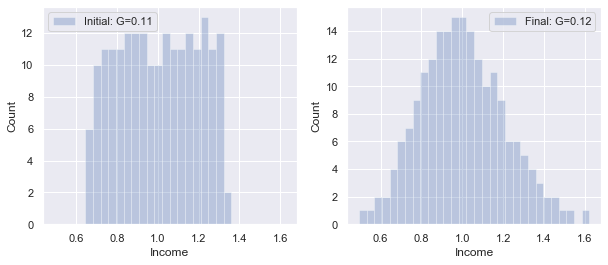

Random


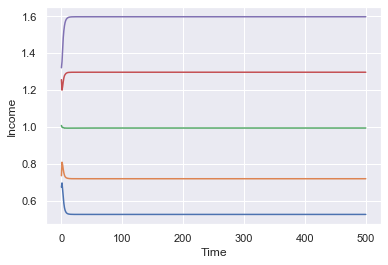

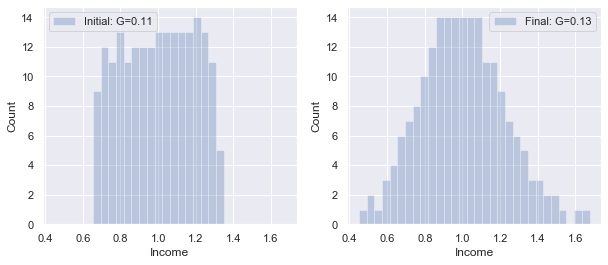

Complete


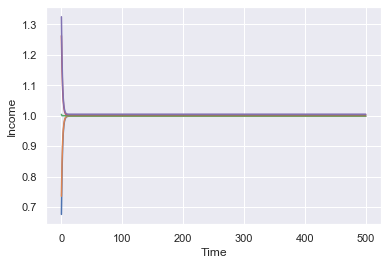

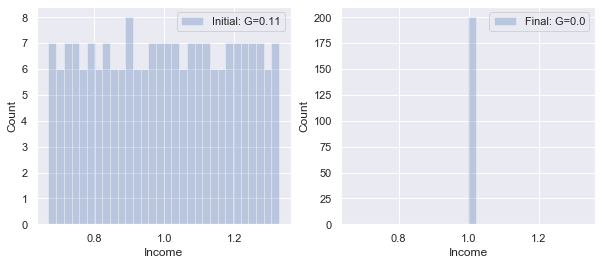

Clusters


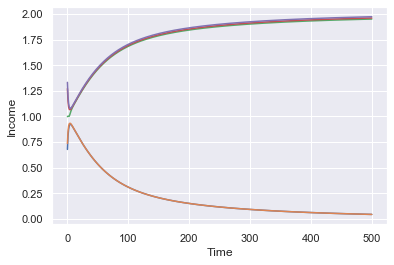

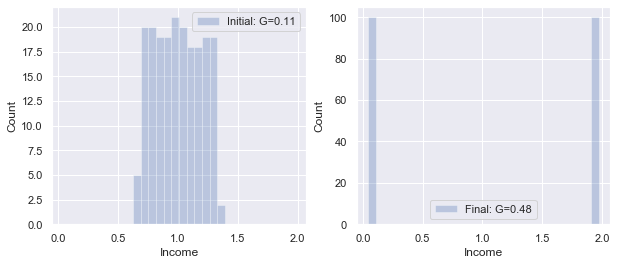

Special Case


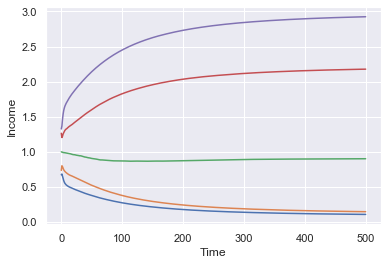

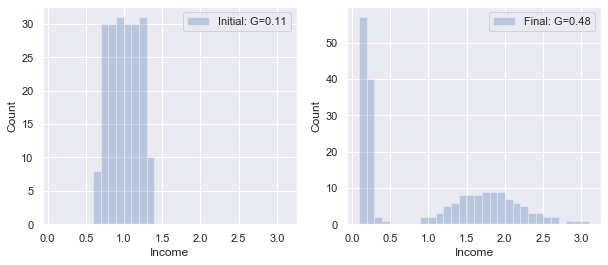

In [86]:
'''

In this function, we are averaging the results from the same network structure
through time, and analyzing initial and final income distribution.

'''

#Population 200


networks = ['Small World', 'Random', 'Complete', 'Clusters', 'Special Case']

for i in networks:
    print(i)
    all_df = []
            
    
    for _ in range(30): 
        sim = interactive_kem(network = i, network_size =200)
        normalized, results, norm_sorted_results, sorted_results, times = sim.simulate(steps = 500) #(5 steps (with initial dist))
        
        norm_df = pd.DataFrame(sorted_results)
        all_df.append(norm_df)
        
    df_concat = pd.concat(all_df)
    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    lst_means = df_means.values.tolist()
    
    show(lst_means, df_means)

## Scaling

We will be analyzing the income distribution of the models throughout time. To do this, we will be running the simulation with different grid sizes, recording the income outputs.


In [323]:
def sizes_network(network_type):
    
    sizes = [i for i in range(10, 510, 10)]


    percs = []
    means = []
    medians = []
    stds = []

    for i in sizes:

        percs_ = []
        means_ = []
        medians_ = []
        stds_ = []

        for _ in range(30):

            sim = interactive_kem(network_size = i, network = 'Small World')
            normalized, results, norm_sorted_results, sorted_results, times = sim.simulate(steps = 500)

            lines_df = pd.DataFrame(sim.lines)

            percs_.append(list(lines_df.iloc[:,-1]))
            means_.append(stats.mean(results[-1]))
            medians_.append(stats.median(results[-1]))
            stds_.append(stats.stdev(results[-1]))

        percs.append([*map(mean, zip(*percs_))])
        means.append(means_)
        medians.append(medians_)
        stds.append(stds_)
    
    return percs, means, medians, stds


In [324]:
def split_percs(percs):
    '''
    Separate percentile values for table use
    '''
    perc_1 = []
    perc_10 = []
    perc_50 = []
    perc_90 = []
    perc_99 = []

    for i in percs:
        
        perc_1.append(i[0])
        perc_10.append(i[1])
        perc_50.append(i[2])
        perc_90.append(i[3])
        perc_99.append(i[4])
        
    return perc_1, perc_10, perc_50, perc_90, perc_99

In [325]:
def means_all(means):
    lst = []
    for i in means:
        lst.append(np.mean(i))
    return lst

In [326]:
percs_sw, means_sw, medians_sw, stds_sw = sizes_network('Small World')
perc_1_sw, perc_10_sw, perc_50_sw, perc_90_sw, perc_99_sw = split_percs(percs_sw)

In [327]:
percs_cl_2, means_cl_2, medians_cl_2, stds_cl_2 = sizes_network('Clusters')
perc_1_cl_2, perc_10_cl_2, perc_50_cl_2, perc_90_cl_2, perc_99_cl_2 = split_percs(percs_cl_2)

In [328]:
percs_sc, means_sc, medians_sc, stds_sc = sizes_network('Special Case')
perc_1_sc, perc_10_sc, perc_50_sc, perc_90_sc, perc_99_sc = split_percs(percs_sc)

In [329]:
sizes = [i for i in range(10, 510, 10)]

### Small World Network

In [330]:
data_small_world = pd.DataFrame({'Sizes' : sizes,
                                 'Mean': means_all(means_sw),
                                 'perc_1': perc_1_sw,
                                 'perc_10': perc_10_sw,
                                 'perc_50': perc_50_sw,
                                 'perc_90': perc_90_sw,
                                 'perc_99': perc_99_sw,
                                })   

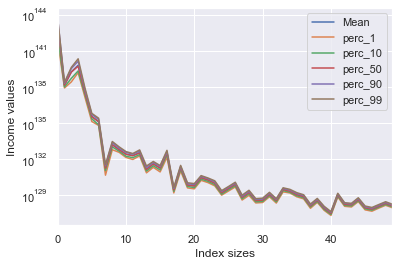

In [331]:
data = data_small_world.loc[:, data_small_world.columns != 'Sizes']
data.plot()
plt.xlabel("Index sizes")
plt.ylabel("Income values")
plt.yscale('log')
plt.show()

### Clusters 

In [332]:
data_clusters_2 = pd.DataFrame({'Sizes' : sizes,
                            'Mean': means_all(means_cl_2),
                            'perc_1': perc_1_cl_2,
                            'perc_10': perc_10_cl_2,
                            'perc_50': perc_50_cl_2,
                            'perc_90': perc_90_cl_2,
                            'perc_99': perc_99_cl_2,
                               })     

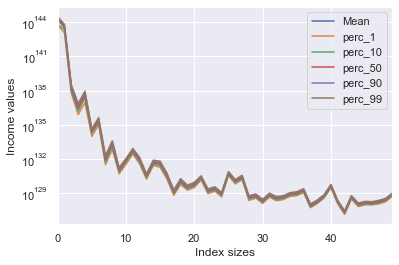

In [333]:
data_1 = data_clusters_2.loc[:, data_clusters_2.columns != 'Sizes']
data_1.plot()
plt.xlabel("Index sizes")
plt.ylabel("Income values")
plt.yscale('log')
plt.show()

### Special Case

In [334]:

data_sc= pd.DataFrame({'Sizes' : sizes,
                    'Mean': means_all(means_sc),
                    'perc_1': perc_1_sc,
                    'perc_10': perc_10_sc,
                    'perc_50': perc_50_sc,
                    'perc_90': perc_90_sc,
                    'perc_99': perc_99_sc,
                      })     

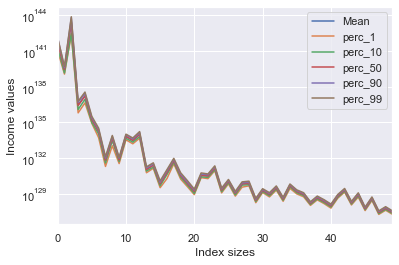

In [345]:
data_2 = data_sc.loc[:, data_sc.columns != 'Sizes']
data_2.plot()
plt.xlabel("Index sizes")
plt.ylabel("Income values")
plt.yscale('log')
plt.show()

### Comparison of Statistical Moments

In [340]:
#Unnormalized income (both of them)
def plot_stat_moments(means, medians, stds):
    
    
    mean_ = []
    for i in means:
       mean_.append(stats.mean(i))
    
    median_ = []
    for i in medians:
       median_.append(stats.mean(i))
    
    std_ = []
    for i in stds:
        std_.append(stats.mean(i))
    
    
    plt.figure()
    plt.plot(sizes, means,'o', markersize=2)
    plt.plot(sizes, mean_, marker='.', color='red', alpha=0.8, markersize =12, linewidth=0)
    plt.xlabel('Network Size')
    plt.ylabel('Income Mean')
    plt.yscale('log')
    plt.show()
    
    
    plt.figure()
    plt.plot(sizes, medians,'o', markersize=2)
    plt.plot(sizes, median_, marker='.', color='red', alpha=0.8, markersize =12, linewidth=0)
    plt.xlabel('Network Size')
    plt.ylabel('Income Median')
    plt.yscale('log')
    plt.show()
    
    plt.figure()
    plt.plot(sizes, stds,'o', markersize=2)
    plt.plot(sizes, std_, marker='.', color='red', alpha=0.8, markersize =12, linewidth=0)
    plt.xlabel('Network Size')
    plt.ylabel('Income std')
    plt.yscale('log')
    plt.show()

#### Small World 

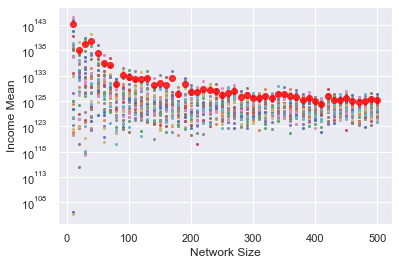

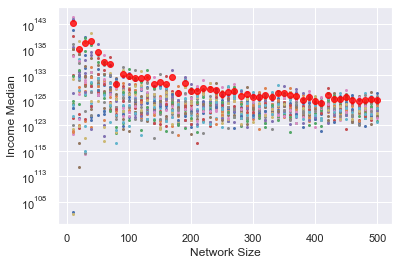

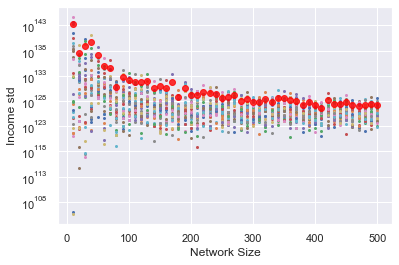

In [341]:
plot_stat_moments(means_sw, medians_sw, stds_sw)

#### Clusters

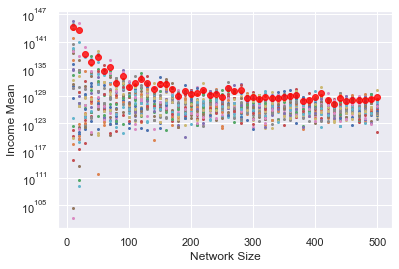

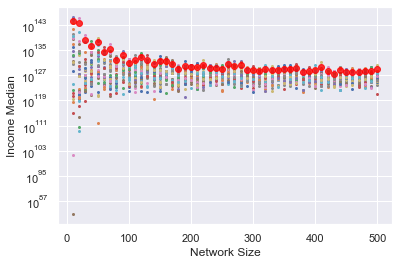

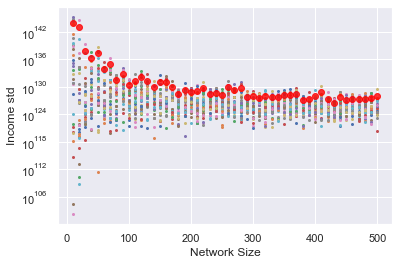

In [342]:
plot_stat_moments(means_cl_2, medians_cl_2, stds_cl_2)

#### Special Case

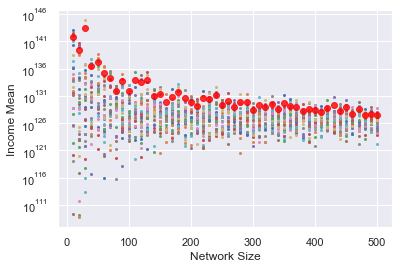

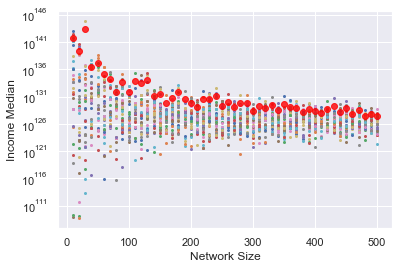

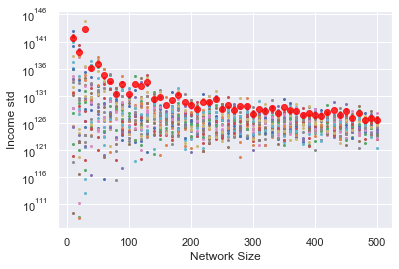

In [343]:
plot_stat_moments(means_sc, medians_sc, stds_sc)

### Plotting distribution change (Animation)

In [0]:
'''
Plotting/Animated the change of final distribution for different city sizes.

'''
def animate(i):
    
    plt.cla()
    
    lbl = "Population = "+ str(sizes[i])
    sns.distplot(hists_1[i], kde= True, label=lbl)

    plt.xlabel('Income')
#     plt.xscale('log')
#     plt.yscale('log')
    plt.ylabel('Count')
    
    plt.grid(True)
    plt.legend()

anim = FuncAnimation(plt.figure(), animate, frames=len(hists_1))
HTML(anim.to_jshtml())